In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import SVG
import sys
import pandas as pd
import platform
import sklearn as sk
import scipy as sp

# %matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Masking, Reshape, Dense, Conv2D, MaxPooling2D, UpSampling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tqdm.keras import TqdmCallback

c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

# --------------------------------------------------------------------------------
# VAE Custom
# --------------------------------------------------------------------------------

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        # batch = tf.shape(z_mean)[0]
        # dim = tf.shape(z_mean)[1]
        # epsilon = tf.random.normal(shape=(batch, dim))
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.klweight = 10
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def set_klweight(self, w):
        self.klweight = w

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_squared_error(data, reconstruction)
                    # keras.losses.binary_crossentropy(data, reconstruction)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = self.klweight*reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [4]:

X = pd.read_csv("datasetMedico.csv")
dataset_inputs = X.iloc[:,:-1].values.reshape(X.shape[0], 28, 28, 1)
dataset_labels = X.iloc[:,-1].values
dataset_inputs = dataset_inputs.astype("float32")/255.

print('dataset_inputs shape:', dataset_inputs.shape)
print(dataset_inputs.shape[0], 'samples')

dataset_inputs shape: (820, 28, 28, 1)
820 samples


In [5]:

dataset_inputs = dataset_inputs.reshape((len(dataset_inputs), np.prod(dataset_inputs.shape[1:])))
code_size = 2
nentradas = dataset_inputs.shape[1]


In [6]:

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"SciPy {sp.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: Windows-10-10.0.19045-SP0
Tensor Flow Version: 2.14.0

Python 3.11.3 (tags/v3.11.3:f3909b8, Apr  4 2023, 23:49:59) [MSC v.1934 64 bit (AMD64)]
Pandas 2.1.0
Scikit-Learn 1.3.0
SciPy 1.11.2
GPU is NOT AVAILABLE


In [7]:

#
# Encoder network
#
VANILLA = False
if VANILLA:
    hidden_size = 256
    encoder_inputs = keras.Input(shape=(nentradas,))
    capa1 = layers.Dense(hidden_size, activation="sigmoid",name="capa1")(encoder_inputs)    
else:
    hidden_size = 256
    encoder_inputs  = keras.Input(shape=(nentradas,)) 
    rsh1 = Reshape((28,28,-1))(encoder_inputs)
    conv1_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(rsh1)
    pool1 = MaxPooling2D((2, 2), padding='same')(conv1_1)
    conv1_2 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2), padding='same')(conv1_2)
    conv1_3 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D((2, 2), padding='same')(conv1_3)
    rshp = Reshape((-1,))(pool3)
    capa1 = layers.Dense(hidden_size, activation="sigmoid", name="capa1")(rshp)

z_mean = layers.Dense(code_size, name="z_mean")(capa1)
z_log_var = layers.Dense(code_size, name="z_log_var")(capa1)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()
# COMPLETAR


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 reshape (Reshape)           (None, 28, 28, 1)            0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 32)           320       ['reshape[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)           0         ['conv2d[0][0]']              
 D)                                                                                         

In [8]:

#
# Decoder network
#
VANILLA = True
if VANILLA:  
    latent_inputs = keras.Input(shape=(code_size,))
    deco1 = layers.Dense(hidden_size, activation="sigmoid")(latent_inputs)
    decoder_outputs = layers.Dense(nentradas, activation="sigmoid")(deco1)
else:
    latent_inputs = keras.Input(shape=(code_size,))
    hidden2 = 16
    deco1 = layers.Dense(hidden2, activation="sigmoid")(latent_inputs)
    rsh2 = Reshape((4,4,-1))(deco1)
    conv2_1 = Conv2D(16, (3,3), activation='relu', padding='same')(rsh2)
    # up1 = UpSampling2D((2, 2))(conv2_1)
    # conv2_2 = Conv2D(16, (3, 3), activation='relu', padding='same')(up1)
    # up2 = UpSampling2D((2, 2))(conv2_2)
    # conv2_3 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
    # up3 = UpSampling2D((2, 2))(conv2_3)
    rsh3 = Reshape((-1,))(conv2_1)
    decoder_outputs = layers.Dense(nentradas, activation="sigmoid")(rsh3)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

# COMPLETAR


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 256)               768       
                                                                 
 dense_1 (Dense)             (None, 784)               201488    
                                                                 
Total params: 202256 (790.06 KB)
Trainable params: 202256 (790.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:

#
# Compile the VAE
#
vae = VAE(encoder, decoder)
vae.set_klweight(100)
vae.compile(optimizer=tf.keras.optimizers.legacy.Adam())


In [35]:

#
# Entrenamiento
#

history = vae.fit(dataset_inputs, epochs=2000, batch_size=150 ,verbose=0, callbacks=[TqdmCallback(verbose=0)])
#Hay que buscar los valores que mejoren la visualización.
#Las épocas se refieren al número de veces que el modelo verá todo el conjunto de datos de entrenamiento. 
#El tamaño del batch se refiere a cuántas muestras de datos se utilizan en cada iteración de entrenamiento antes de actualizar los pesos del modelo.


100%|██████████| 2000/2000 [06:37<00:00,  5.04epoch/s, loss=66, reconstruction_loss=0.595, kl_loss=6.48]  


dict_keys(['loss', 'reconstruction_loss', 'kl_loss'])


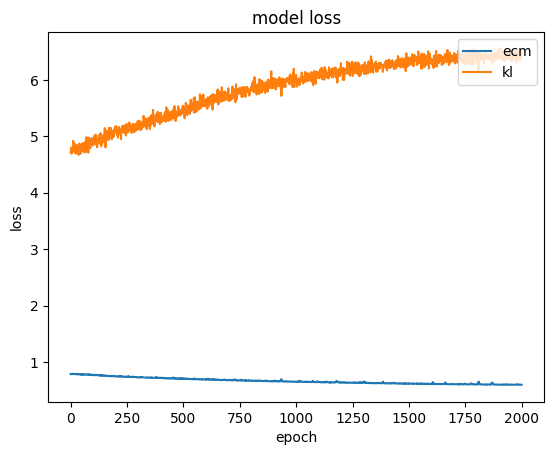

In [36]:

print(history.history.keys())

plt.plot(history.history['reconstruction_loss'])
plt.plot(history.history['kl_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['ecm', 'kl'], loc='upper right')
plt.show()

In [37]:

# Prediccion
encoded_imgs,_,_ = vae.encoder.predict(dataset_inputs)
decoded_imgs = vae.decoder.predict(encoded_imgs)


26/26 [==============================] - 0s 1ms/step


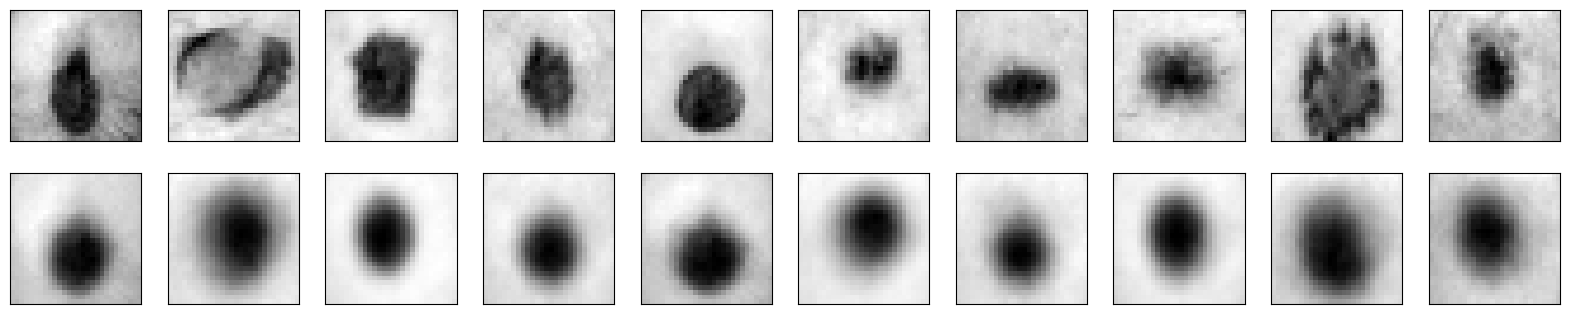

In [38]:
#Muestra una comparación entre imágenes originales y sus reconstrucciones utilizando un modelo de autoencoder variacional (VAE)
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(dataset_inputs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

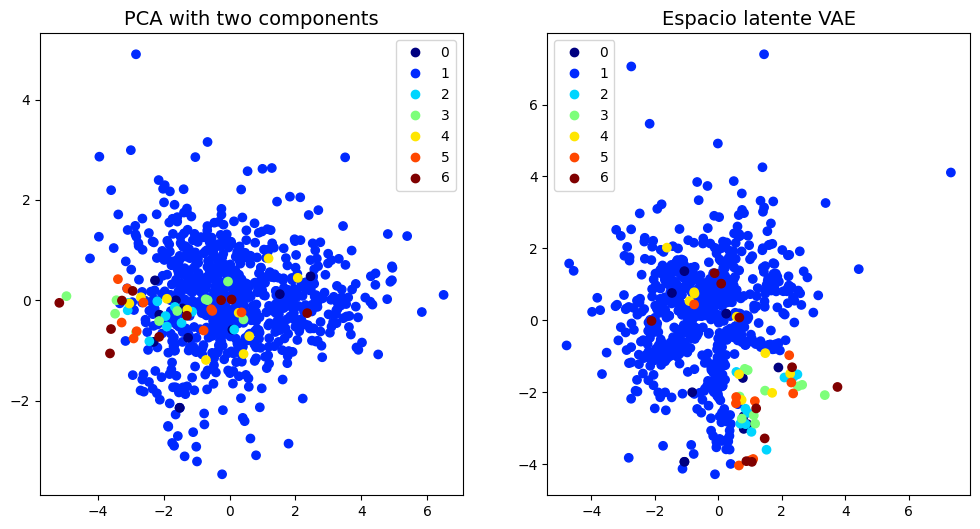

In [39]:
#
# COMPLETAR
#

import matplotlib as mpl
cmap = plt.cm.jet  
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
bounds = np.arange(10)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

N = 5000
pvae = encoded_imgs.reshape(-1,code_size)
pvae = pvae[:N,:]
points = dataset_inputs.reshape(-1,784)
points = points[:N,:]

fig = plt.figure(figsize=(12,6))

from sklearn.decomposition import PCA
#PCA
pca = PCA(n_components=2)
pca.fit(points)
X_pca = pca.transform(points)

ax = fig.add_subplot(1, 2, 1)
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=dataset_labels,cmap=cmap)
ax.legend(*scatter.legend_elements())
ax.set_title('PCA with two components', size=14)
#ESPACIO LATENTE
ax = fig.add_subplot(1, 2, 2)
scatter = ax.scatter(pvae[:, 0], pvae[:, 1], c=dataset_labels,cmap=cmap)
ax.set_title('Espacio latente VAE', size=14)
ax.legend(*scatter.legend_elements())
plt.savefig("latente.pdf")
plt.show()
plt.close()
